In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import tbparse
from typing import List, Dict
import numpy as np
import glob
import json
plt.rcParams["font.family"] = "arial"
plt.rc('font', size=12)
cm = 1/2.54

import matplotlib
plt.rc('font', family='serif')
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler('color', plt.get_cmap('Dark2').colors)

## Simulation Kurvendurchfahrt

In [153]:
alpha = np.linspace(0,np.pi/2, 50)
r=1
zero = np.array([[1], [-1]])
b_l = np.array([[1], [1.7]])
width = 4

In [154]:
p_mitte_ftf = lambda alpha: zero + r * np.array([[-np.sin(alpha)], [np.cos(alpha)]])

In [155]:
p_ecke_scanner = lambda alpha: p_mitte_ftf(alpha) + np.matmul(np.array([[-np.sin(alpha), -np.cos(alpha)],[np.cos(alpha), -np.sin(alpha)]]), b_l)

In [156]:
data_ecke = np.concatenate([[np.array([width,b_l[0,0]])]]+[p_ecke_scanner(alpha).transpose() for alpha in np.linspace(0, np.pi/2, 50)]+[[np.array([-b_l[0,0], -width])]]).transpose()

In [157]:
data_mitte = np.concatenate([[np.array([width,0])]]+[p_mitte_ftf(alpha).transpose() for alpha in np.linspace(0, np.pi/2, 50)]+[[np.array([0, -width])]]).transpose()

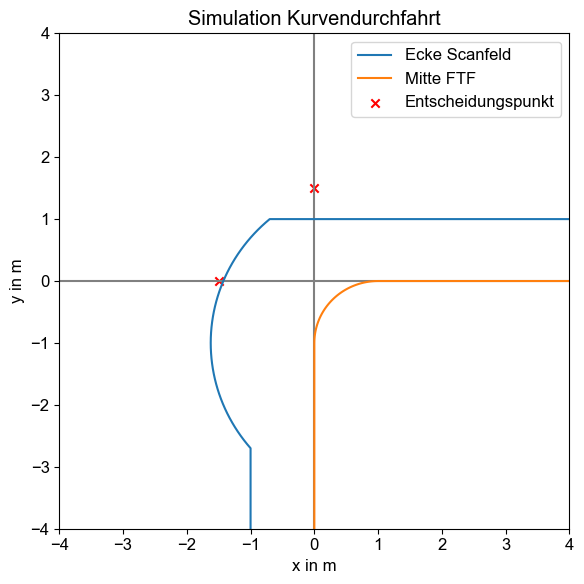

In [169]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.vlines(0, -width, width, colors="gray")
ax.hlines(0, -width, width, colors="gray")
ax.plot(data_ecke[0], data_ecke[1], label="Ecke Scanfeld")
ax.plot(data_mitte[0], data_mitte[1], label="Mitte FTF")
ax.scatter([-1.5, 0], [0, 1.5], marker="x", c="red", label="Entscheidungspunkt")
#ax.annotate("Entscheidungspunkt FTF1", (-1.5, 0), (-3.8, 1), arrowprops=dict(arrowstyle="->"))
#ax.annotate("Entscheidungspunkt FTF2", (0, 1.5), (-3, 3), arrowprops=dict(arrowstyle="->"))
ax.set_xlim(-width, width)
ax.set_ylim(-width, width)
ax.set_xlabel("x in m")
ax.set_ylabel("y in m")
ax.legend()
ax.set_title("Simulation Kurvendurchfahrt")
fig.tight_layout()
fig.savefig("Kollisionsverhalten.svg", dpi=600)

## Tools

In [2]:
def find_tag(df:pd.DataFrame, search:str):
    return [tag for tag in df["tag"].unique() if search in tag]

def filter_tag(df, tags: List[str] or str):
    if isinstance(tags, str):
        filtered = df[df["tag"] == tags][["step", "value"]].set_index("step")
    else:
        filtered = {tag: filter_tag(df, tag) for tag in tags}
    return filtered

def mean(dfs: List[pd.DataFrame] or Dict[List[pd.DataFrame]]):
    if isinstance(dfs, dict):
        return {tag: mean(df) for tag, df in dfs.items()}
    else:
        full_data:pd.DataFrame = dfs[0]
        for i, df in enumerate(dfs[1:]):
            full_data = full_data.join(df, rsuffix=str(i), how="outer")
        full_data.interpolate(inplace = True)
        mean_data = pd.DataFrame(full_data.mean(axis=1), columns=["value"])
        return mean_data
    
def mean_min_max(dfs: List[pd.DataFrame] or Dict[List[pd.DataFrame]], std = False):
    if isinstance(dfs, dict):
        return {tag: mean_min_max(df, std=std) for tag, df in dfs.items()}
    else:
        full_data:pd.DataFrame = dfs[0]
        for i, df in enumerate(dfs[1:]):
            full_data = full_data.join(df, rsuffix=str(i), how="outer")
        full_data.interpolate(inplace = True)
        agg = ["mean", "min", "max"] if not std else ["mean", "sum", np.std]
        mean_data = full_data.agg(agg, axis="columns") if len(full_data)>0 else pd.DataFrame(columns=("","",""))
        mean_data.columns = ["value", "min", "max"]
        if std:
            mean_data["min"] = mean_data["value"] - mean_data["max"]
            mean_data["max"] = mean_data["value"] + mean_data["max"]
        return mean_data

def import_data(path, run_name, tags: List[str] or str = None, exclude = []) -> List[pd.DataFrame] or Dict[List[pd.DataFrame]]:
    assert isinstance(exclude, list), "Exclude has to be a List"
    experiments = glob.glob(path + "/" + run_name + "*")
    experiments = [exp for exp in experiments if not any([exc in exp for exc in exclude])]
    dfs = {tag:[] for tag in tags} if isinstance(tags, list) else []
    for experiment in experiments:
        data = tbparse.SummaryReader(experiment).scalars
        if tags is not None:
            data = filter_tag(data, tags)
        if isinstance(data, dict):
            for tag in data.keys():
                dfs[tag].append(data[tag])
        else:
            dfs.append(data)
    return dfs

def import_json(path, tags: List[str] or str = None) -> List[pd.DataFrame] or Dict[List[pd.DataFrame]]:
    with open(path) as json_file:
        json_data = json.load(json_file)

    dfs = {tag:[] for tag in tags} if isinstance(tags, list) else []
    experiments = json_data[list(json_data.keys())[0]].keys()
    for tag in tags:
        for experiment in experiments:
            data = {k:v[experiment][tag] for k,v in json_data.items() if experiment in v.keys() and tag in v[experiment].keys()}
            dfs[tag].append(pd.DataFrame(pd.Series(data), columns = ["value"]))
    return dfs

def plot(dfs, labels, x_label, y_label, ax_ = None, reduce_ticks = False, no_legend = False, legend_args = {}):
    if ax_ is None:
        fig, ax = plt.subplots()
    else:
        ax = ax_
    for df, label in zip(dfs, labels):
        master = ax.plot(df.index, df["value"], label=label, linewidth = 1.5)
        if "min" in df.columns:
            ax.plot(df.index, df["min"], linewidth = .3, c = master[0].get_c())
            ax.plot(df.index, df["max"], linewidth = .3, c = master[0].get_c())  
            ax.fill_between(df.index, df["min"], df["max"], alpha=.1)
    if not no_legend: 
        ax.legend(**legend_args)
    ax.yaxis.grid(True, linestyle = "--")
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    if reduce_ticks: 
        ax.set_xticks(ax.get_xticks())
    if ax_ is None:
        return fig

# Routing Experimente in Minimatrix

In [3]:
path = "../../logs/minimatrix_routing/"

## Single Agent vs Multi Agent

In [4]:
results_sa = mean_min_max(import_data(path, "01_konzept_sa", 'ray/tune/episode_reward_mean'))
results_ma = mean_min_max(import_data(path, "01_konzept_ma", 'ray/tune/episode_reward_mean'))

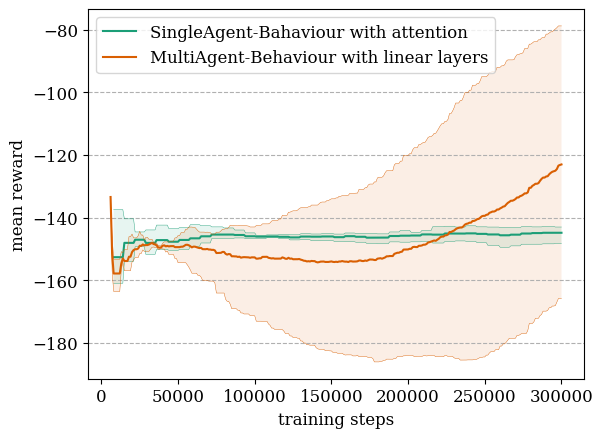

In [5]:
fig = plot([results_sa, results_ma], ["SingleAgent-Bahaviour with attention", "MultiAgent-Behaviour with linear layers"], "training steps", "mean reward")

In [6]:
fig.savefig("../../../Schreiben/Bilder/MiniMatrix_01.svg", dpi=600)

## Algorithmus Auswahl

In [7]:
results_ppo = mean_min_max(import_data(path, "01_konzept_ma", 'ray/tune/episode_reward_mean'))
results_a2c = mean_min_max(import_data(path, "02_algorithmus_a2c", 'ray/tune/episode_reward_mean'))
results_apex = mean_min_max(import_data(path, "02_algorithmus_apex", 'ray/tune/episode_reward_mean'))
results_dqn = mean_min_max(import_data(path, "02_algorithmus_dqn", 'ray/tune/episode_reward_mean'))
results_rainbow = mean_min_max(import_data(path, "02_algorithmus_rainbow", 'ray/tune/episode_reward_mean'))

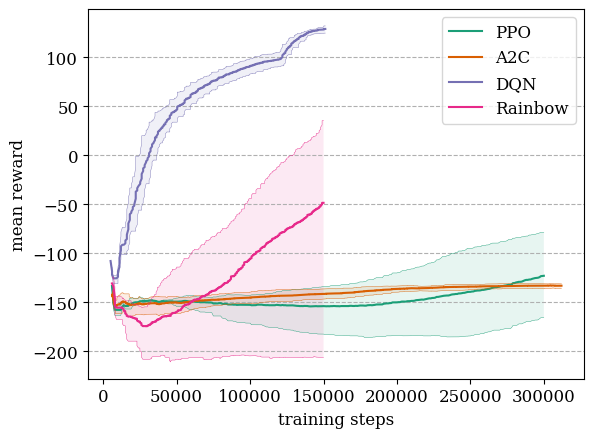

In [8]:
fig = plot([results_ppo, results_a2c, results_dqn, results_rainbow], ["PPO", "A2C",  "DQN", "Rainbow"], "training steps", "mean reward")

In [9]:
fig.savefig("../../../Schreiben/Bilder/MiniMatrix_02.svg", dpi=600)

## Auswahl Gammawert

In [10]:
results_098 = mean_min_max(import_data(path, "02_algorithmus_dqn", 'ray/tune/episode_reward_mean'))
results_0999 = mean_min_max(import_data(path, "03_gamma_0_999", 'ray/tune/episode_reward_mean'))
results_09 = mean_min_max(import_data(path, "03_gamma_0_9_", 'ray/tune/episode_reward_mean'))

## Learning Rate

In [11]:
results_3 = mean_min_max(import_data(path, "03_gamma_0_9_", 'ray/tune/episode_reward_mean'))
results_4 = mean_min_max(import_data(path, "04_lr_e4", 'ray/tune/episode_reward_mean'))
results_5 = mean_min_max(import_data(path, "04_lr_e5", 'ray/tune/episode_reward_mean'))

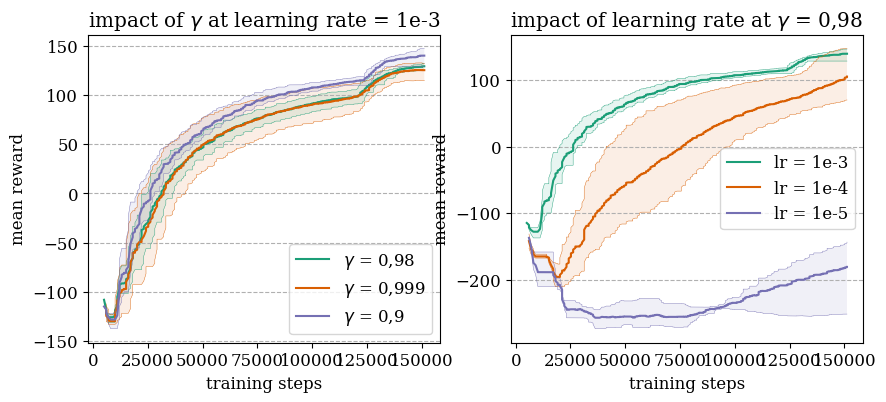

In [12]:
fig, axs = plt.subplots(1,2, figsize = (10,4))
axs[0].set_title("impact of $\gamma$ at learning rate = 1e-3")
plot([results_098, results_0999, results_09], ["$\gamma$ = 0,98", "$\gamma$ = 0,999", "$\gamma$ = 0,9"], "training steps", "mean reward", axs[0])
axs[1].set_title("impact of learning rate at $\gamma$ = 0,98")
plot([results_3, results_4, results_5], ["lr = 1e-3", "lr = 1e-4", "lr = 1e-5"], "training steps", "mean reward", axs[1])

In [13]:
fig.tight_layout()
fig.savefig("../../../Schreiben/Bilder/MiniMatrix_03.svg", dpi=600)

## Model

In [14]:
tags = ['ray/tune/episode_reward_mean', 'ray/tune/custom_metrics/block_mean']
results_lin = mean_min_max(import_data(path, "03_gamma_0_9_", tags))
results_attn = mean_min_max(import_data(path, "05_model_attn", tags))
results_gnn = mean_min_max(import_data(path, "05_model_gnn", tags, exclude = ["09-34"]))

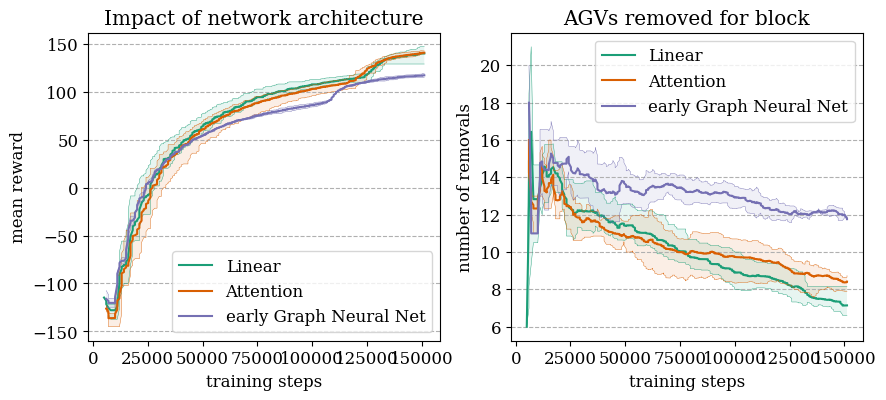

In [15]:
fig, axs = plt.subplots(1,2, figsize = (10,4))
axs[0].set_title("Impact of network architecture")
plot([results_lin[tags[0]], results_attn[tags[0]], results_gnn[tags[0]]], ["Linear", "Attention", "early Graph Neural Net"], "training steps", "mean reward", axs[0])
axs[1].set_title("AGVs removed for block")
plot([results_lin[tags[1]], results_attn[tags[1]], results_gnn[tags[1]]], ["Linear", "Attention", "early Graph Neural Net"], "training steps", "number of removals", axs[1])

In [16]:
fig.tight_layout()
fig.savefig("../../../Schreiben/Bilder/MiniMatrix_04.svg", dpi=600)

## Modellbreite

In [17]:
results_16 = mean_min_max(import_data(path, "06_embed_16", 'ray/tune/episode_reward_mean'))
results_32 = mean_min_max(import_data(path, "03_gamma_0_9_", 'ray/tune/episode_reward_mean'))
results_64 = mean_min_max(import_data(path, "06_embed_64", 'ray/tune/episode_reward_mean'))

## Action Masking

In [18]:
results_with_am = mean_min_max(import_data(path, "07_action_masking_on__2_10_2023-01-01_19-01-24262oqu3p", 'ray/tune/episode_reward_mean'))
results_without_am = mean_min_max(import_data(path, "06_embed_64", 'ray/tune/episode_reward_mean'))

## Coordinate Embedding

In [19]:
results_without = mean_min_max(import_data(path, "06_embed_64", 'ray/tune/episode_reward_mean'))
results_embedding = mean_min_max(import_data(path, "08_position_embedding", 'ray/tune/episode_reward_mean'))
results_fourier = mean_min_max(import_data(path, "08_position_fourier", 'ray/tune/episode_reward_mean', exclude=["17-28-58"]))

## Episodenlänge

In [20]:
results_never = mean_min_max(import_data(path, "08_position_fourier", 'ray/tune/episode_reward_mean', exclude=["17-28-58"]))
results_block = mean_min_max(import_data(path, "09_episode_block", 'ray/tune/episode_reward_mean'))
results_target = mean_min_max(import_data(path, "09_episode_target", 'ray/tune/episode_reward_mean', exclude=["18-27-32", "04-52-24"]))

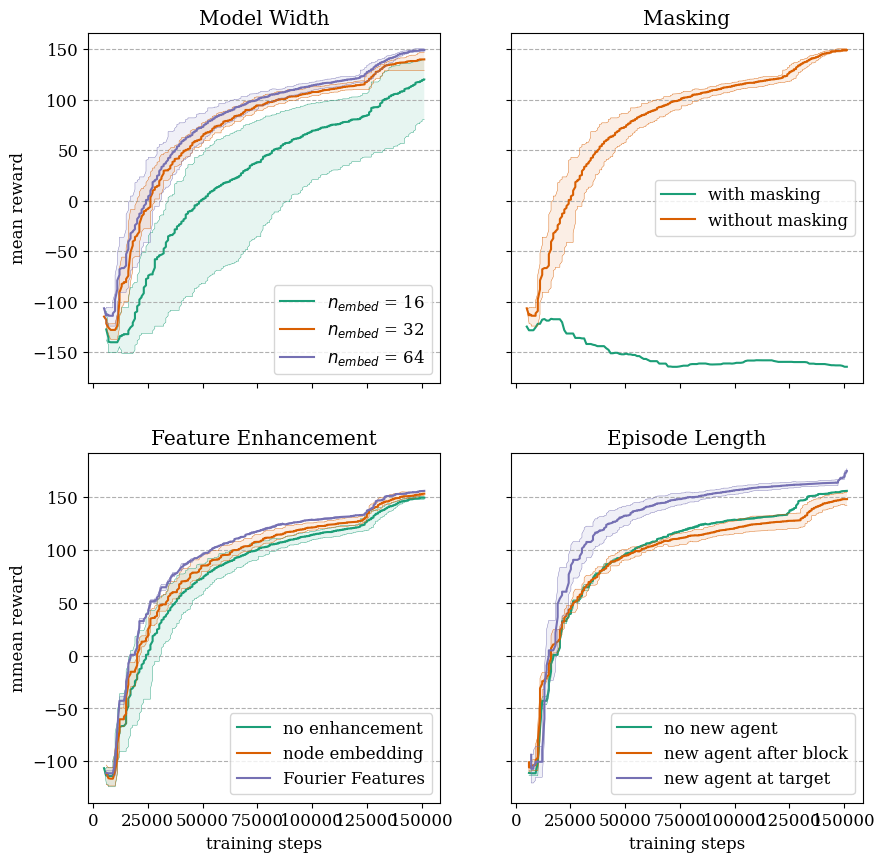

In [21]:
fig = plt.figure(figsize = (10,10))
ax00 = fig.add_subplot(2,2,1)
ax00.set_title("Model Width")
plot([results_16, results_32, results_64], ["$n_{embed}$ = 16", "$n_{embed}$ = 32", "$n_{embed}$ = 64"], "training steps", "mean reward", ax00)
ax00.set_xlabel(None)
plt.tick_params("x", labelbottom = False)
ax01 = fig.add_subplot(2,2,2, sharey=ax00)
ax01.set_title("Masking")
plot([results_with_am, results_without_am], ["with masking", "without masking"], "training steps", "mean reward", ax01)
ax01.set_ylabel(None)
ax01.set_xlabel(None)
plt.tick_params("x", labelbottom = False)
plt.tick_params("y", labelleft = False)
ax10 = fig.add_subplot(2,2,3, sharex=ax00)
ax10.set_title("Feature Enhancement")
plot([results_without, results_embedding, results_fourier], ["no enhancement", "node embedding", "Fourier Features"], "training steps", "mmean reward", ax10)
ax11 = fig.add_subplot(2,2,4, sharey=ax10, sharex=ax01)
ax11.set_title("Episode Length")
plot([results_never, results_block, results_target], ["no new agent", "new agent after block", "new agent at target"], "training steps", "mean reward", ax11)
ax11.set_ylabel(None)
plt.tick_params("y", labelleft = False)

In [22]:
fig.tight_layout()
fig.savefig("../../../Schreiben/Bilder/MiniMatrix_05.svg", dpi=600)

# Routing-Experimente in Matrix

In [23]:
path = "../../logs/matrix_routing/"

## Model

In [24]:
tags = ['ray/tune/episode_reward_mean', "ray/tune/custom_metrics/block_mean", "ray/tune/custom_metrics/targetReached_mean", "ray/tune/custom_metrics/taken_invalid_mean"]
results_lin = mean_min_max(import_data(path, "01_model_lin", tags))
results_attn = mean_min_max(import_data(path, "01_model_attn", tags))
results_gnn = mean_min_max(import_data(path, "01_model_gnn", tags))


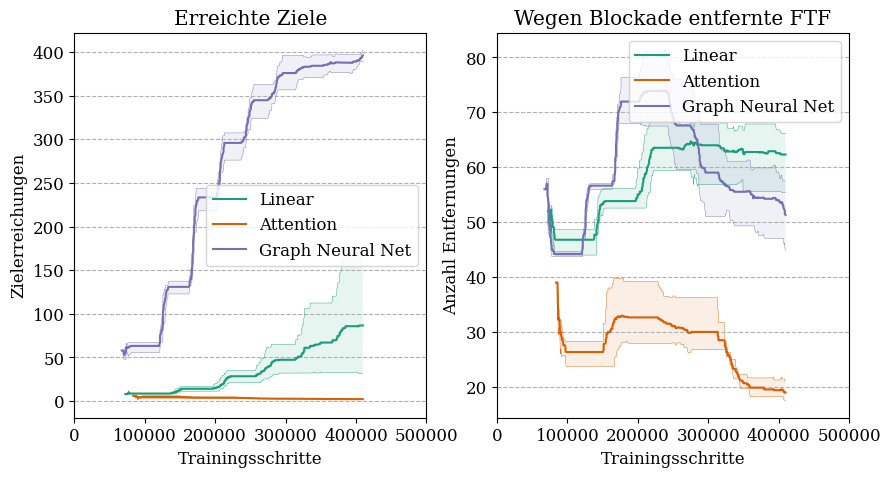

In [25]:
fig, axs = plt.subplots(1,2, figsize = (10,5))
axs[0].set_title("Erreichte Ziele")
plot([results_lin[tags[2]], results_attn[tags[2]], results_gnn[tags[2]]], ["Linear", "Attention", "Graph Neural Net"], "Trainingsschritte", "Zielerreichungen", axs[0], reduce_ticks = True)
axs[1].set_title("Wegen Blockade entfernte FTF")
plot([results_lin[tags[1]], results_attn[tags[1]], results_gnn[tags[1]]], ["Linear", "Attention", "Graph Neural Net"], "Trainingsschritte", "Anzahl Entfernungen", axs[1], reduce_ticks = True)

In [26]:
fig.tight_layout()
fig.savefig("../../../Schreiben/Bilder/Routing_01.svg", dpi=600)

## Gamma

In [27]:
tags = ['ray/tune/episode_reward_mean', "ray/tune/custom_metrics/block_mean", "ray/tune/custom_metrics/targetReached_mean", "ray/tune/custom_metrics/taken_invalid_mean"]
results_9 = mean_min_max(import_data(path, "02_gamma_0_9_", tags))
results_98 = mean_min_max(import_data(path, "01_model_gnn", tags))
results_999 = mean_min_max(import_data(path, "02_gamma_0_999_", tags))

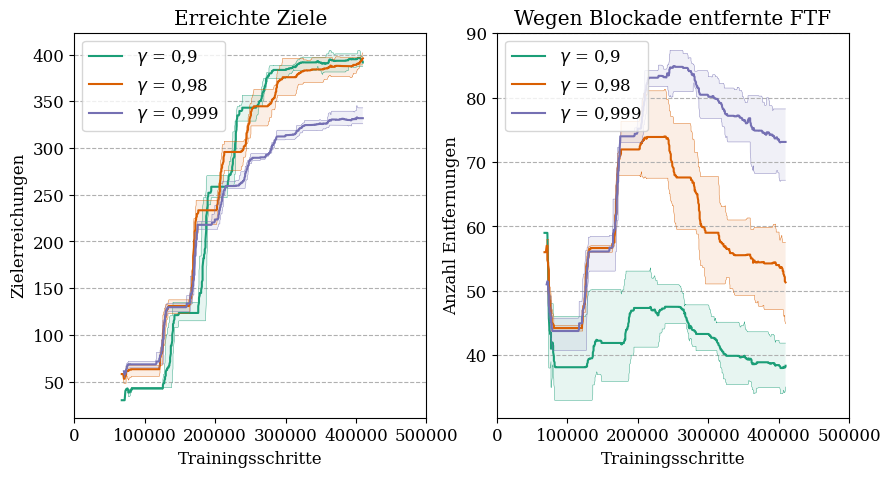

In [28]:
fig, axs = plt.subplots(1,2, figsize = (10,5))
axs[0].set_title("Erreichte Ziele")
plot([results_9[tags[2]], results_98[tags[2]], results_999[tags[2]]], ["$\gamma$ = 0,9", "$\gamma$ = 0,98", "$\gamma$ = 0,999"], "Trainingsschritte", "Zielerreichungen", axs[0], reduce_ticks = True)
axs[1].set_title("Wegen Blockade entfernte FTF")
plot([results_9[tags[1]], results_98[tags[1]], results_999[tags[1]]], ["$\gamma$ = 0,9", "$\gamma$ = 0,98", "$\gamma$ = 0,999"], "Trainingsschritte", "Anzahl Entfernungen", axs[1], reduce_ticks = True)

In [29]:
fig.tight_layout()
fig.savefig("../../../Schreiben/Bilder/Routing_02.svg", dpi=600)

## Learning Rate

In [30]:
tags = ['ray/tune/episode_reward_mean', "ray/tune/custom_metrics/block_mean", "ray/tune/custom_metrics/targetReached_mean", "ray/tune/custom_metrics/taken_invalid_mean"]
results_3 = mean_min_max(import_data(path, "02_gamma_0_9_", tags))
results_4 = mean_min_max(import_data(path, "03_lr_1e-4", tags))


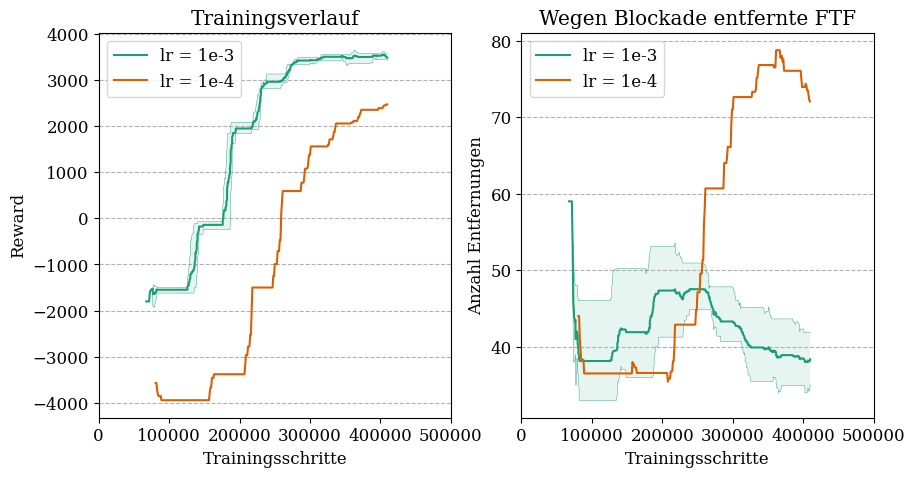

In [31]:
fig, axs = plt.subplots(1,2, figsize = (10,5))
axs[0].set_title("Trainingsverlauf")
plot([results_3[tags[0]], results_4[tags[0]]],  ["lr = 1e-3", "lr = 1e-4"], "Trainingsschritte", "Reward", axs[0], reduce_ticks = True)
axs[1].set_title("Wegen Blockade entfernte FTF")
plot([results_3[tags[1]], results_4[tags[1]]],  ["lr = 1e-3", "lr = 1e-4"], "Trainingsschritte", "Anzahl Entfernungen", axs[1], reduce_ticks = True)

In [32]:
fig.tight_layout()
fig.savefig("../../../Schreiben/Bilder/Routing_03.svg", dpi=600)

## Episodenende

In [33]:
tags = ['ray/tune/episode_reward_mean', "ray/tune/custom_metrics/block_mean", "ray/tune/custom_metrics/targetReached_mean", "ray/tune/custom_metrics/taken_invalid_mean"]
results_none = mean_min_max(import_data(path, "02_gamma_0_9_", tags))
results_block = mean_min_max(import_data(path, "04_episode_block", tags))
results_target = mean_min_max(import_data(path, "04_episode_target", tags))

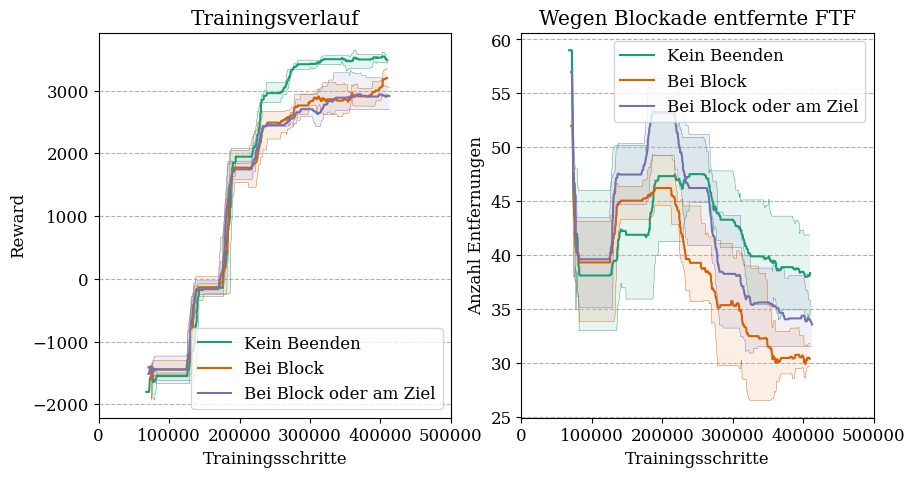

In [34]:
fig, axs = plt.subplots(1,2, figsize = (10,5))
axs[0].set_title("Trainingsverlauf")
plot([results_none[tags[0]], results_block[tags[0]], results_target[tags[0]]], ["Kein Beenden", "Bei Block", "Bei Block oder am Ziel"], "Trainingsschritte", "Reward", axs[0], reduce_ticks = True)
axs[1].set_title("Wegen Blockade entfernte FTF")
plot([results_none[tags[1]], results_block[tags[1]], results_target[tags[1]]], ["Kein Beenden", "Bei Block", "Bei Block oder am Ziel"], "Trainingsschritte", "Anzahl Entfernungen", axs[1], reduce_ticks = True)

In [35]:
fig.tight_layout()
fig.savefig("../../../Schreiben/Bilder/Routing_04.svg", dpi=600)

## Rewards

In [36]:
tags = ['ray/tune/episode_reward_mean', "ray/tune/custom_metrics/block_mean", "ray/tune/custom_metrics/targetReached_mean", "ray/tune/custom_metrics/taken_invalid_mean"]
results_none = mean_min_max(import_data(path, "04_episode_block", tags))
results_dir = mean_min_max(import_data(path, "04_rew_dir_-0_1_", tags, exclude=["11-16-50"]))
results_dist = mean_min_max(import_data(path, "05_rew_dist_-0_1", tags, exclude = ["01-02-55"]))
results_block = mean_min_max(import_data(path, "06_rew_blck_", tags))

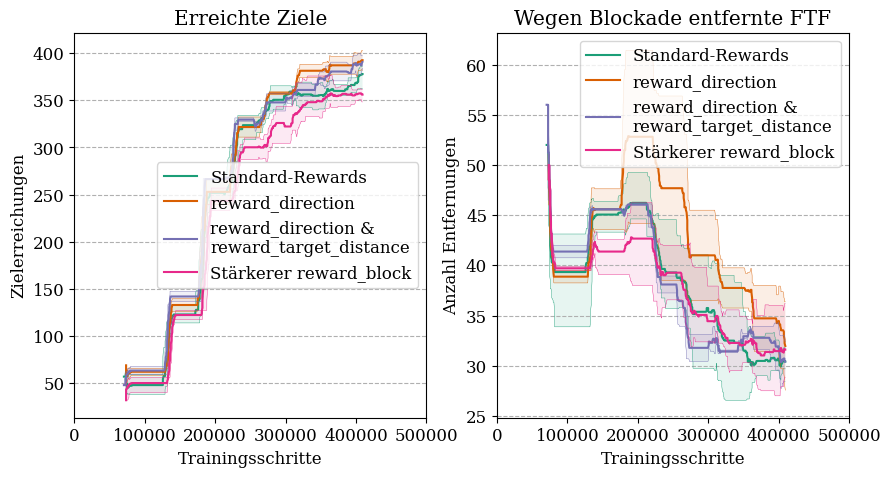

In [37]:
fig, axs = plt.subplots(1,2, figsize = (10,5))
axs[0].set_title("Erreichte Ziele")
plot([results_none[tags[2]], results_dir[tags[2]], results_dist[tags[2]], results_block[tags[2]]], ["Standard-Rewards", "reward_direction", "reward_direction & \nreward_target_distance", "Stärkerer reward_block"], "Trainingsschritte", "Zielerreichungen", axs[0], reduce_ticks = True)
axs[1].set_title("Wegen Blockade entfernte FTF")
plot([results_none[tags[1]], results_dir[tags[1]], results_dist[tags[1]], results_block[tags[1]]], ["Standard-Rewards", "reward_direction", "reward_direction & \nreward_target_distance", "Stärkerer reward_block"], "Trainingsschritte", "Anzahl Entfernungen", axs[1], reduce_ticks = True)

In [38]:
fig.tight_layout()
fig.savefig("../../../Schreiben/Bilder/Routing_05.svg", dpi=600)

## Matrix Rebuild

In [39]:
tags = ['ray/tune/episode_reward_mean', "ray/tune/custom_metrics/block_mean", "ray/tune/custom_metrics/targetReached_mean", "ray/tune/custom_metrics/taken_invalid_mean"]
results_before = mean_min_max(import_data(path, "04_rew_dir_-0_1_", tags, exclude=["11-16-50"]))
results_after = mean_min_max(import_data(path, "08_new_base", tags))
results_pass = mean_min_max(import_data(path, "08_rew_pass", tags))
results_block = mean_min_max(import_data(path, "10_final5", tags))

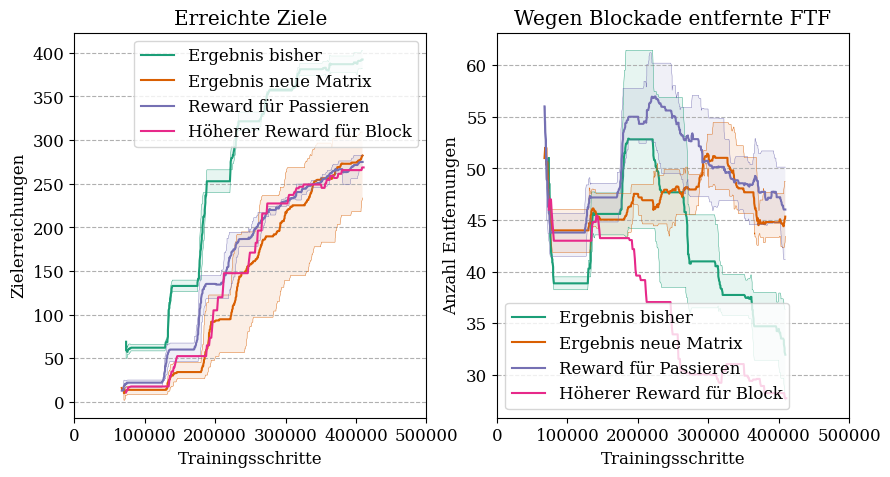

In [40]:
fig, axs = plt.subplots(1,2, figsize = (10,5))
axs[0].set_title("Erreichte Ziele")
plot([results_before[tags[2]], results_after[tags[2]], results_pass[tags[2]], results_block[tags[2]]], ["Ergebnis bisher", "Ergebnis neue Matrix", "Reward für Passieren", "Höherer Reward für Block"], "Trainingsschritte", "Zielerreichungen", axs[0], reduce_ticks = True)
axs[1].set_title("Wegen Blockade entfernte FTF")
plot([results_before[tags[1]], results_after[tags[1]], results_pass[tags[1]], results_block[tags[1]]], ["Ergebnis bisher", "Ergebnis neue Matrix", "Reward für Passieren", "Höherer Reward für Block"], "Trainingsschritte", "Anzahl Entfernungen", axs[1], reduce_ticks = True)

In [41]:
fig.tight_layout()
fig.savefig("../../../Schreiben/Bilder/Routing_06.svg", dpi=600)

# Dispatching-Experimente in Matrix

In [42]:
path = "../../logs/matrix_dispatching/"

## Multi-Agent vs. Single-Agent & Algorithmus & Model

In [43]:
results_ma = mean_min_max(import_data(path, "01_kozept_ma", 'ray/tune/episode_reward_mean'))
results_sa = mean_min_max(import_data(path, "01_kozept_sa", 'ray/tune/episode_reward_mean'))
results_dqn = mean_min_max(import_data(path, "02_algo_am_dqn", 'ray/tune/episode_reward_mean'))
results_attn = mean_min_max(import_data(path, "03_model_attn", 'ray/tune/episode_reward_mean'))

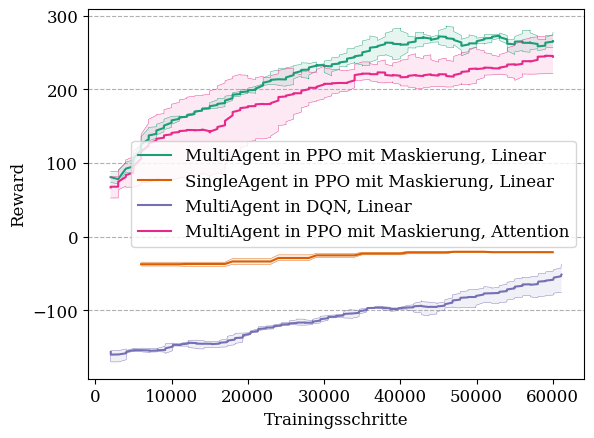

In [44]:
fig = plot([results_ma, results_sa, results_dqn, results_attn], ["MultiAgent in PPO mit Maskierung, Linear", "SingleAgent in PPO mit Maskierung, Linear", "MultiAgent in DQN, Linear", "MultiAgent in PPO mit Maskierung, Attention"], "Trainingsschritte", "Reward")

In [45]:
fig.tight_layout()
fig.savefig("../../../Schreiben/Bilder/Dispatching_01.svg", dpi=600)

## Gamma & LR

In [46]:
results_98 = mean_min_max(import_data(path, "01_kozept_ma", 'ray/tune/episode_reward_mean'))
results_9 = mean_min_max(import_data(path, "04_gamma_0_9", 'ray/tune/episode_reward_mean'))
results_3 = mean_min_max(import_data(path, "05_lr_e-3", 'ray/tune/episode_reward_mean'))
results_4 = mean_min_max(import_data(path, "01_kozept_ma", 'ray/tune/episode_reward_mean'))
results_5 = mean_min_max(import_data(path, "05_lr_e-5", 'ray/tune/episode_reward_mean', exclude=["00-48-23"]))

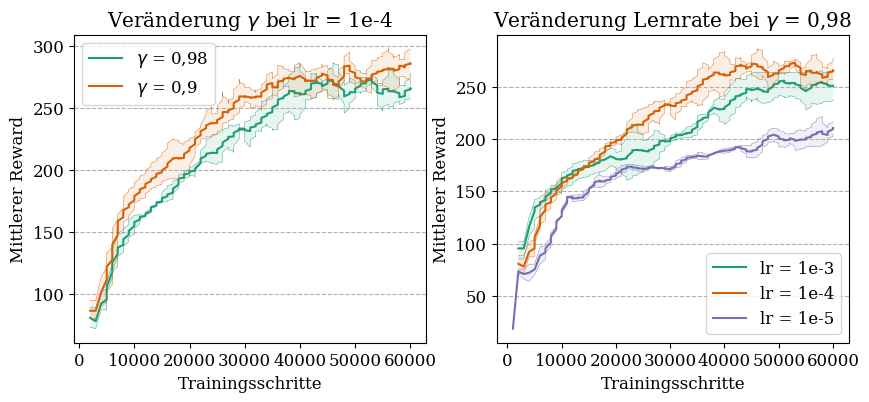

In [47]:
fig, axs = plt.subplots(1,2, figsize = (10,4))
axs[0].set_title("Veränderung $\gamma$ bei lr = 1e-4")
plot([results_98, results_9], ["$\gamma$ = 0,98", "$\gamma$ = 0,9"], "Trainingsschritte", "Mittlerer Reward", axs[0])
axs[1].set_title("Veränderung Lernrate bei $\gamma$ = 0,98")
plot([results_3, results_4, results_5], ["lr = 1e-3", "lr = 1e-4", "lr = 1e-5"], "Trainingsschritte", "Mittlerer Reward", axs[1])

In [48]:
fig.tight_layout()
fig.savefig("../../../Schreiben/Bilder/Dispatching_02.svg", dpi=600)

## Feature Engineering, Prozess-Rewards

In [49]:
tags = ["ray/tune/custom_metrics/jobDone_mean", "ray/tune/custom_metrics/liveLock_mean"]

results_none = mean_min_max(import_data(path, "04_gamma_0_9", tags))
results_no_fe = mean_min_max(import_data(path, "06_feature_eng", tags))
results_process_rew = mean_min_max(import_data(path, "07_rew_conf_process", tags))

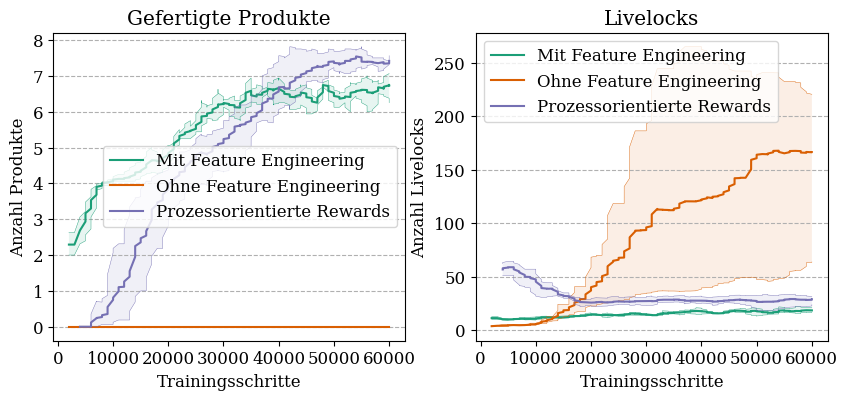

In [50]:
fig, axs = plt.subplots(1,2, figsize = (10,4))
axs[0].set_title("Gefertigte Produkte")
plot([results_none[tags[0]], results_no_fe[tags[0]], results_process_rew[tags[0]]], ["Mit Feature Engineering", "Ohne Feature Engineering", "Prozessorientierte Rewards"], "Trainingsschritte", "Anzahl Produkte", axs[0])
axs[1].set_title("Livelocks")
plot([results_none[tags[1]], results_no_fe[tags[1]], results_process_rew[tags[1]]], ["Mit Feature Engineering", "Ohne Feature Engineering", "Prozessorientierte Rewards"], "Trainingsschritte", "Anzahl Livelocks", axs[1])

In [51]:
fig.tight_layout()
fig.savefig("../../../Schreiben/Bilder/Dispatching_03.svg", dpi=600)

## Prozessorientierter Transport

In [52]:
tags = [
    "ray/tune/custom_metrics/_jobnum_hgeo1_mean", 
    "ray/tune/custom_metrics/_jobnum_hgeo2_mean", 
    "ray/tune/custom_metrics/_jobnum_hgeo3_mean", 
    "ray/tune/custom_metrics/_jobnum_hgeo4_mean", 
    "ray/tune/custom_metrics/_jobnum_hgeo5_mean",
    "ray/tune/custom_metrics/_jobnum_vgeo1_mean", 
    "ray/tune/custom_metrics/_jobnum_vgeo2_mean", 
    "ray/tune/custom_metrics/_jobnum_vgeo3_mean",
    "ray/tune/custom_metrics/_jobnum_vgeo4_mean", 
    "ray/tune/custom_metrics/_jobnum_vgeo5_mean", 
    "ray/tune/custom_metrics/_jobnum_vgeo6_mean", ]

results_none = mean_min_max(import_data(path, "07_rew_conf_process", tags))
results_seperate= mean_min_max(import_data(path, "08_seperate", tags))

In [53]:
null_frame = pd.DataFrame([[0,0,0] for _ in range(len(results_seperate[tags[0]]))], columns=["value", "min", "max"], index=results_seperate[tags[0]].index)

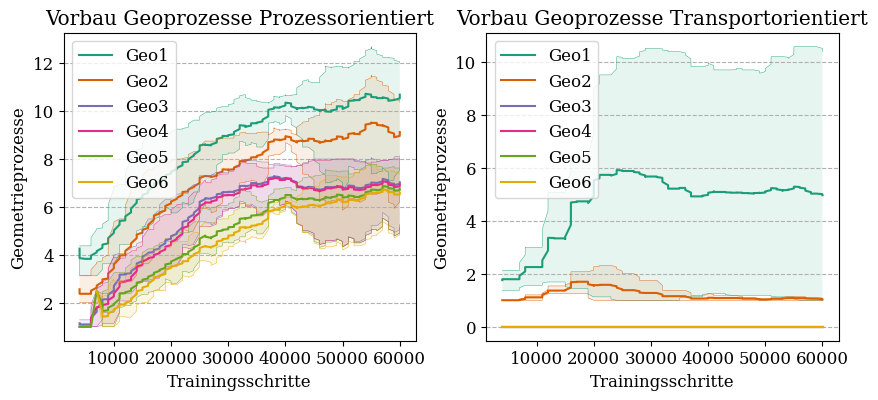

In [54]:
fig, axs = plt.subplots(1,2, figsize = (10,4))
axs[0].set_title("Vorbau Geoprozesse Prozessorientiert")
plot([results_none[tags[5]], results_none[tags[6]], results_none[tags[7]], results_none[tags[8]], results_none[tags[9]], results_none[tags[10]]], ["Geo1", "Geo2", "Geo3", "Geo4", "Geo5", "Geo6"], "Trainingsschritte", "Geometrieprozesse", axs[0])
axs[1].set_title("Vorbau Geoprozesse Transportorientiert")
plot([results_seperate[tags[5]], results_seperate[tags[6]], null_frame, null_frame, null_frame, null_frame], ["Geo1", "Geo2", "Geo3", "Geo4", "Geo5", "Geo6"], "Trainingsschritte", "Geometrieprozesse", axs[1])

In [55]:
fig.tight_layout()
fig.savefig("../../../Schreiben/Bilder/Dispatching_04.svg", dpi=600)

## Verteilng VB-HC

In [56]:
tags = [
    "ray/tune/custom_metrics/_jobnum_hgeo1_mean", 
    "ray/tune/custom_metrics/_jobnum_hgeo5_mean",
    "ray/tune/custom_metrics/_jobnum_vgeo1_mean", 
    "ray/tune/custom_metrics/_jobnum_vgeo6_mean", ]

results_none = mean_min_max(import_data(path, "07_rew_conf_process", tags))
results_rew_balance = mean_min_max(import_data(path, "09_rew_balance_-5", tags))
results_two_balance = mean_min_max(import_data(path, "09_rew_balance_two", tags))

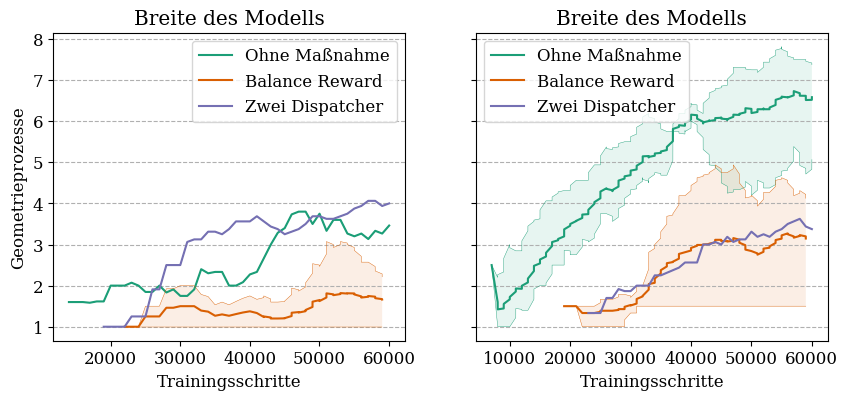

In [57]:
fig = plt.figure(figsize = (10,4))
ax0 = fig.add_subplot(1,2,1)
ax0.set_title("Breite des Modells")
plot([results_none[tags[1]], results_rew_balance[tags[1]].loc[:60000], results_two_balance[tags[1]]], ["Ohne Maßnahme", "Balance Reward", "Zwei Dispatcher"], "Trainingsschritte", "Geometrieprozesse", ax0)

ax1 = fig.add_subplot(1,2,2, sharey=ax0)
plt.tick_params("y", labelleft = False)
ax1.set_title("Breite des Modells")
plot([results_none[tags[3]], results_rew_balance[tags[3]].loc[:60000], results_two_balance[tags[3]]], ["Ohne Maßnahme", "Balance Reward", "Zwei Dispatcher"], "Trainingsschritte", "", ax1)

In [58]:
fig.tight_layout()
fig.savefig("../../../Schreiben/Bilder/Dispatching_05.svg", dpi=600)

## Analyse Dispatching

In [59]:
tags = [
    "ray/tune/custom_metrics/_jobnum_wps_1_mean", 
    "ray/tune/custom_metrics/_jobdur_wps_1_mean", 
    "ray/tune/custom_metrics/_jobnum_wps_2_mean", 
    "ray/tune/custom_metrics/_jobdur_wps_2_mean", 
    "ray/tune/custom_metrics/_jobnum_wps_3_mean", 
    "ray/tune/custom_metrics/_jobdur_wps_3_mean", 
    "ray/tune/custom_metrics/_jobnum_hsn1_1_mean", 
    "ray/tune/custom_metrics/_jobdur_hsn1_1_mean", 
    "ray/tune/custom_metrics/_jobnum_hsn1_2_mean", 
    "ray/tune/custom_metrics/_jobdur_hsn1_2_mean", 
    "ray/tune/custom_metrics/_jobnum_hsn2_1_mean", 
    "ray/tune/custom_metrics/_jobdur_hsn2_1_mean", 
    "ray/tune/custom_metrics/_jobnum_hsn2_2_mean", 
    "ray/tune/custom_metrics/_jobdur_hsn2_2_mean", 
    "ray/tune/custom_metrics/_jobnum_fls_1_mean", 
    "ray/tune/custom_metrics/_jobdur_fls_1_mean", 
    "ray/tune/custom_metrics/_jobnum_fls_2_mean", 
    "ray/tune/custom_metrics/_jobdur_fls_2_mean", 
    "ray/tune/custom_metrics/_jobnum_impact_mean", 
    "ray/tune/custom_metrics/_jobdur_impact_mean", 
    "ray/tune/custom_metrics/_blocksec_agv0_mean",
    "ray/tune/custom_metrics/_blocksec_agv1_mean",
    "ray/tune/custom_metrics/_blocksec_agv2_mean",
    "ray/tune/custom_metrics/_blocksec_agv3_mean",
    "ray/tune/custom_metrics/run_time_mean",
    "ray/tune/custom_metrics/jobDone_mean",
    "ray/tune/custom_metrics/liveLock_mean",
    "ray/tune/episode_reward_mean",
      ]

results_wps = mean(import_data(path, "LAST_4_20_2023-05-31_18-33-05", tags))

In [60]:
for i in range(10):
    results_wps["dur"+str(i+1)] = results_wps[tags[2*i+1]]/results_wps[tags[2*i]]
    results_wps["perc"+str(i+1)] = (results_wps[tags[2*i+1]] + results_wps[tags[2*i]]*20)/36

results_wps["durchlauf"] = results_wps[tags[-4]] / results_wps[tags[-3]]
results_wps["blocksec"] = sum(
    [results_wps[block_sec] for block_sec in [
        "ray/tune/custom_metrics/_blocksec_agv0_mean",
        "ray/tune/custom_metrics/_blocksec_agv1_mean",
        "ray/tune/custom_metrics/_blocksec_agv2_mean",
        "ray/tune/custom_metrics/_blocksec_agv3_mean",
        ]
    ]
)/4

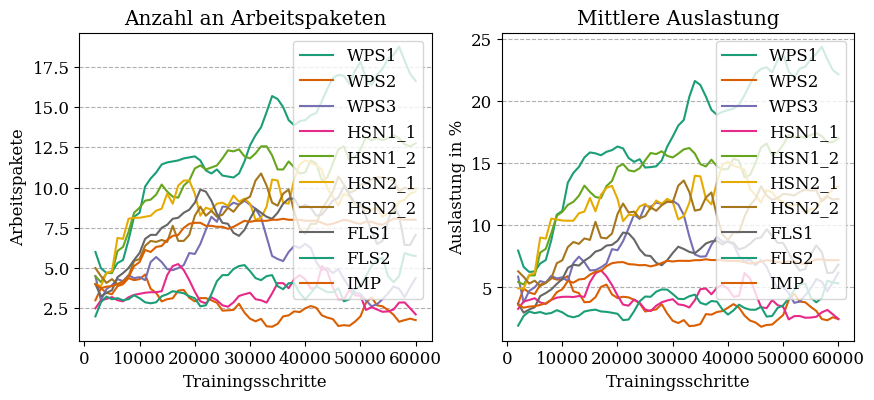

In [61]:
fig, axs = plt.subplots(1,2, figsize = (10,4))
axs[0].set_title("Anzahl an Arbeitspaketen")
plot([results_wps[tags[2*i]] for i in range(10)], ["WPS1", "WPS2", "WPS3","HSN1_1", "HSN1_2","HSN2_1", "HSN2_2","FLS1", "FLS2","IMP", ], "Trainingsschritte", "Arbeitspakete", axs[0])
axs[1].set_title("Mittlere Auslastung")
plot([results_wps["perc" + str(i+1)] for i in range(10)], ["WPS1", "WPS2", "WPS3","HSN1_1", "HSN1_2","HSN2_1", "HSN2_2","FLS1", "FLS2","IMP", ], "Trainingsschritte", "Auslastung in %", axs[1])

In [62]:
fig.tight_layout()
fig.savefig("../../../Schreiben/Bilder/Dispatching_06.svg", dpi=600)

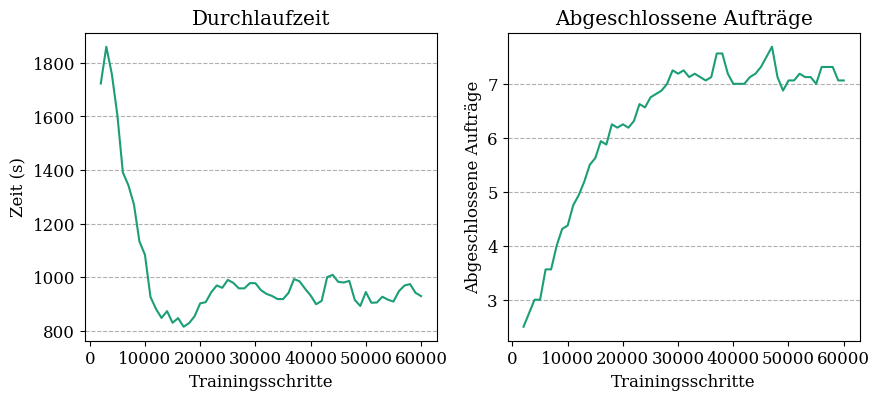

In [63]:
fig, axs = plt.subplots(1,2, figsize = (10,4))
axs[0].set_title("Durchlaufzeit")
plot([results_wps["durchlauf"]], ["", ], "Trainingsschritte", "Zeit (s)", axs[0], no_legend = True)
axs[1].set_title("Abgeschlossene Aufträge")
plot([results_wps[tags[-3]]], ["", ], "Trainingsschritte", "Abgeschlossene Aufträge", axs[1], no_legend = True)

In [64]:
fig.tight_layout()
fig.savefig("../../../Schreiben/Bilder/Dispatching_07.svg", dpi=600)

# Finales Training

In [65]:
path = "../../logs/matrix_together/"

In [66]:
tags = [
    "ray/tune/custom_metrics/targetReached_mean", 
    "ray/tune/custom_metrics/jobDone_mean", 
    "ray/tune/custom_metrics/fleetsize_mean",
    "ray/tune/custom_metrics/taken_invalid_mean",
    "ray/tune/custom_metrics/block_mean",
    "ray/tune/episode_reward_mean",
    "ray/tune/custom_metrics/passed_mean"
      ]


In [67]:

results_full_pseudo = mean_min_max(import_data(path, "LAST_8_20_2023-06-04_09-41-",tags))
results_full_learned = mean_min_max(import_data(path, "LAST_8_20_2023-06-03_01-06-00",tags))

In [68]:
for results in [results_full_pseudo, results_full_learned]:
    results["targets"] = results[tags[0]]/results[tags[2]]
    results["invalid"] = results[tags[3]]/results[tags[2]]
    results["block"] = results[tags[4]]/results[tags[2]]

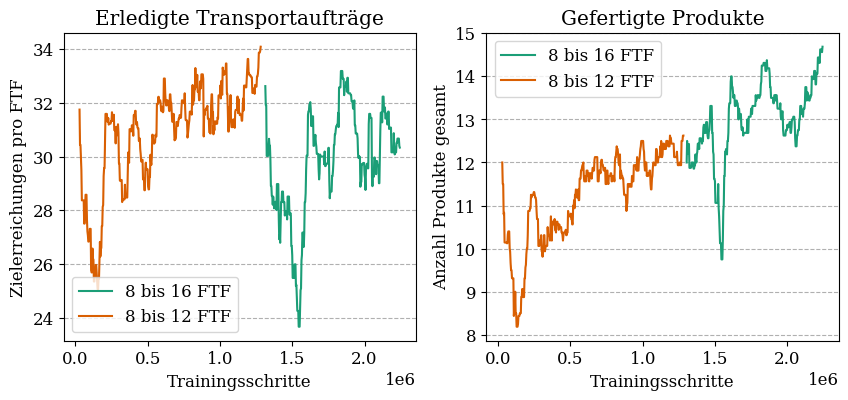

In [69]:
fig, axs = plt.subplots(1,2, figsize = (10,4))
axs[0].set_title("Erledigte Transportaufträge")
plot([results_full_pseudo["targets"].iloc[3:],results_full_learned["targets"]], ["8 bis 16 FTF", "8 bis 12 FTF" ], "Trainingsschritte", "Zielerreichungen pro FTF", axs[0])
axs[1].set_title("Gefertigte Produkte")
plot([results_full_pseudo[tags[1]],results_full_learned[tags[1]] ], ["8 bis 16 FTF", "8 bis 12 FTF" ], "Trainingsschritte", "Anzahl Produkte gesamt", axs[1])

In [70]:
fig.tight_layout()
fig.savefig("../../../Schreiben/Bilder/Together_01.svg", dpi=600)

In [71]:
tags = [
    "ray/tune/custom_metrics/_jobnum_wps_1_mean", 
    "ray/tune/custom_metrics/_jobdur_wps_1_mean", 
    "ray/tune/custom_metrics/_jobnum_wps_2_mean", 
    "ray/tune/custom_metrics/_jobdur_wps_2_mean", 
    "ray/tune/custom_metrics/_jobnum_wps_3_mean", 
    "ray/tune/custom_metrics/_jobdur_wps_3_mean", 
    "ray/tune/custom_metrics/_jobnum_hsn1_1_mean", 
    "ray/tune/custom_metrics/_jobdur_hsn1_1_mean", 
    "ray/tune/custom_metrics/_jobnum_hsn1_2_mean", 
    "ray/tune/custom_metrics/_jobdur_hsn1_2_mean", 
    "ray/tune/custom_metrics/_jobnum_hsn2_1_mean", 
    "ray/tune/custom_metrics/_jobdur_hsn2_1_mean", 
    "ray/tune/custom_metrics/_jobnum_hsn2_2_mean", 
    "ray/tune/custom_metrics/_jobdur_hsn2_2_mean", 
    "ray/tune/custom_metrics/_jobnum_fls_1_mean", 
    "ray/tune/custom_metrics/_jobdur_fls_1_mean", 
    "ray/tune/custom_metrics/_jobnum_fls_2_mean", 
    "ray/tune/custom_metrics/_jobdur_fls_2_mean", 
    "ray/tune/custom_metrics/_jobnum_impact_mean", 
    "ray/tune/custom_metrics/_jobdur_impact_mean", 
      ]

results_wps = mean(import_data(path, "LAST_8", tags))
for i in range(10):
    results_wps["dur"+str(i+1)] = results_wps[tags[2*i+1]]/results_wps[tags[2*i]]
    results_wps["perc"+str(i+1)] = (results_wps[tags[2*i+1]] + results_wps[tags[2*i]]*20)/36

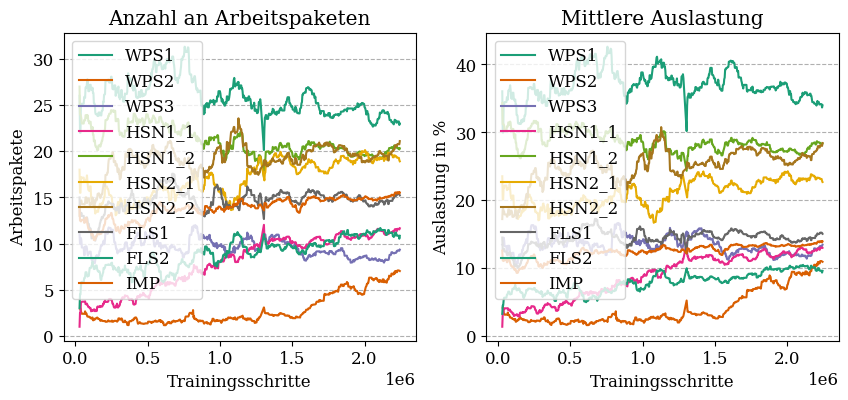

In [72]:
fig, axs = plt.subplots(1,2, figsize = (10,4))
axs[0].set_title("Anzahl an Arbeitspaketen")
plot([results_wps[tags[2*i]] for i in range(10)], ["WPS1", "WPS2", "WPS3","HSN1_1", "HSN1_2","HSN2_1", "HSN2_2","FLS1", "FLS2","IMP", ], "Trainingsschritte", "Arbeitspakete", axs[0])
axs[1].set_title("Mittlere Auslastung")
plot([results_wps["perc" + str(i+1)] for i in range(10)], ["WPS1", "WPS2", "WPS3","HSN1_1", "HSN1_2","HSN2_1", "HSN2_2","FLS1", "FLS2","IMP", ], "Trainingsschritte", "Auslastung in %", axs[1])

# Endergebnis

In [73]:
tags = [
    "targetReached", 
    "jobDone", 
    "fleetsize",
    "taken_invalid",
    "block",
    "run_time",
    *[f"_blocksec_agv{f}" for f in range(20)],
      ]

results_pseudo_bidir = mean(import_json("../../logs/shortest_quene_w_trained.json",tags))
results_pseudo_unidir = mean(import_json("../../logs/finale_pseudo.json",tags))
results_learned = mean(import_json("../../logs/finale5.json",tags))
results_rout = mean(import_json("../../logs/finale_rout.json",tags))
results_disp = mean(import_json("../../logs/finale_disp.json",tags))

In [74]:
for results in [results_pseudo_bidir, results_pseudo_unidir, results_learned, results_disp, results_rout]:
    results["targets"] = results["targetReached"]/results["fleetsize"]
    results["invalid"] = results["taken_invalid"]/results["fleetsize"]
    results["bl"] = results["block"]/results["fleetsize"]
    results["run"] = results["run_time"]/results["jobDone"]
    results["run_time"].index = results["run_time"].index.astype(int)
    blocksec = [results[f"_blocksec_agv{f}"] for f in range(20) if f"_blocksec_agv{f}" in results.keys()]
    for bs in blocksec[1:]:
        blocksec[0] = blocksec[0].add(bs, fill_value = 0)
    results["blocksec"] = blocksec[0]/results["fleetsize"]
    for tag in results.keys():
        results[tag].index = results[tag].index.astype(int)
        results[tag] = results[tag].sort_index()

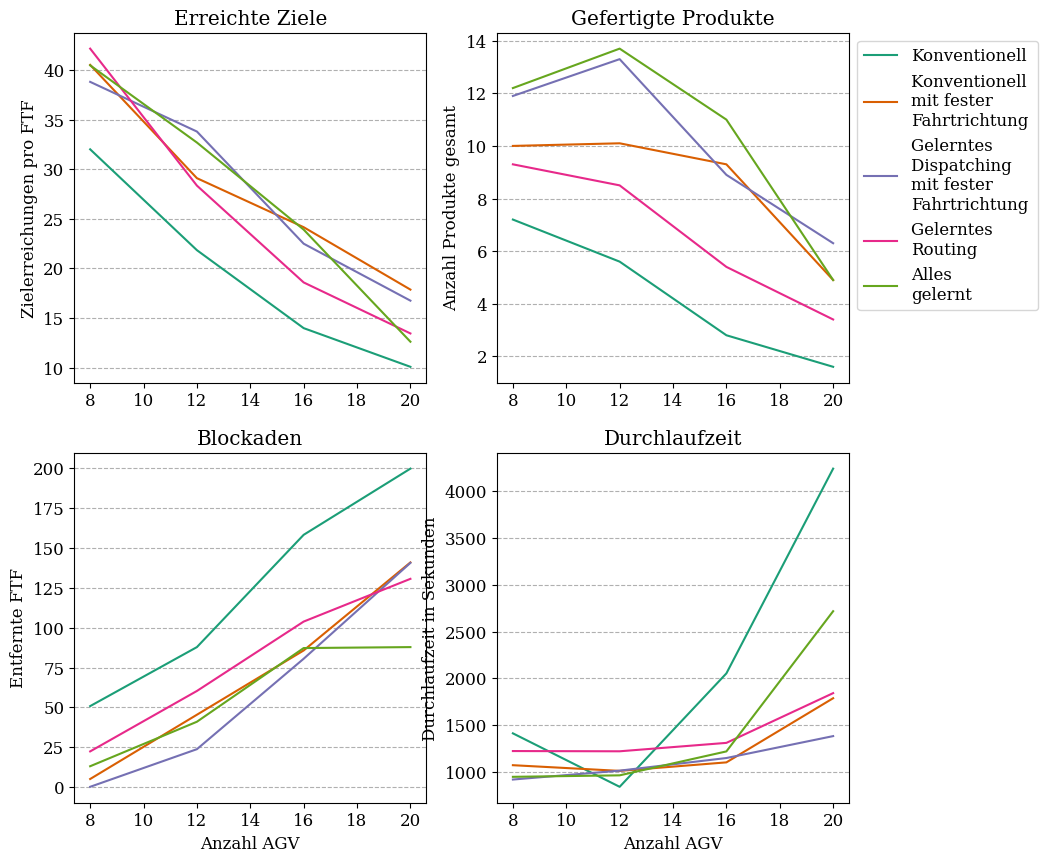

In [75]:
labels = ["Konventionell","Konventionell \nmit fester \nFahrtrichtung", "Gelerntes \nDispatching \nmit fester \nFahrtrichtung", "Gelerntes \nRouting" , "Alles \ngelernt"]
fig, axs = plt.subplots(2,2, figsize = (10,10))
axs[0,0].set_title("Erreichte Ziele")
plot([results_pseudo_bidir["targets"],results_pseudo_unidir["targets"], results_disp["targets"],results_rout["targets"],results_learned["targets"]], labels , "Anzahl AGV", "Zielerreichungen pro FTF", axs[0,0], no_legend = True)
axs[0,0].set_xlabel(None)
axs[0,1].set_title("Gefertigte Produkte")
plot([results_pseudo_bidir[tags[1]],results_pseudo_unidir[tags[1]], results_disp[tags[1]],results_rout[tags[1]],results_learned[tags[1]]], labels, "Anzahl AGV", "Anzahl Produkte gesamt", axs[0,1], legend_args = dict(bbox_to_anchor=(1, 1)))
axs[0,1].set_xlabel(None)
axs[1,0].set_title("Blockaden")
plot([results_pseudo_bidir["block"],results_pseudo_unidir["block"], results_disp["block"],results_rout["block"],results_learned["block"]], labels, "Anzahl AGV", "Entfernte FTF", axs[1,0], no_legend = True)
axs[1,1].set_title("Durchlaufzeit")
plot([results_pseudo_bidir["run"],results_pseudo_unidir["run"], results_disp["run"],results_rout["run"],results_learned["run"]], labels, "Anzahl AGV", "Durchlaufzeit in Sekunden", axs[1,1], no_legend = True)

In [76]:
fig.tight_layout()
fig.savefig("../../../Schreiben/Bilder/Together_02.svg", dpi=600)